# Pneumonia_Diagnosis

Goal of this project:
1. Build a CNN-based deep learning model that processes medical images is well implemented.
2. Experiment data preparation and model construction were systematically performed.
3. Run Pneumonia detection accuracy was further improved by improving the practice code.

# Table of Contents
1. Load the Data
2. Data Preparation
3. Data Visualization
4. CNN Modeling
5. Handle Data Imbalance
6. Mdel Train
7. Result and Visualization

# Dataset
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

# What is Pneumonia?

"""   
Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli.[3][14] Symptoms typically include some combination of productive or dry cough, chest pain, fever, and difficulty breathing.[1] The severity of the condition is variable.[1]

Pneumonia is usually caused by infection with viruses or bacteria, and less commonly by other microorganisms.[a] Identifying the responsible pathogen can be difficult. Diagnosis is often based on symptoms and physical examination.[8] Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.[8] The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.   
"""

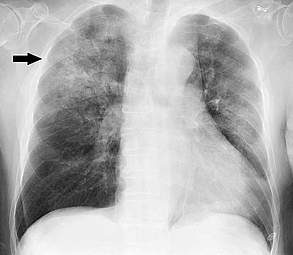

A normal chest X-RAY (left) shows a clear lung with no abnormal shaded areas in the image.   
Bacterial pneumonia (middle) is usually represented in the upper right lobe (white arrow), whereas viral pneumonia (right) appears in a more diffuse "interstitial" pattern in both lungs.

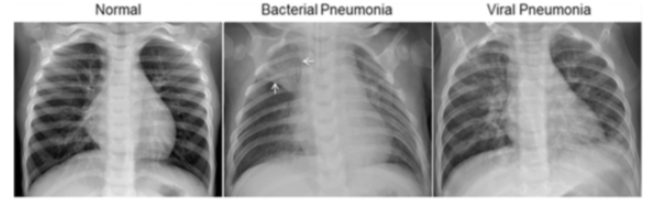

As shown above, in the photos with pneumonia, you can see that the features form a pattern.   
Do you think a deep learning algorithm that can read these patterns well can learn enough?    
As deep learning algorithms are called a kind of pattern recognition algorithm,
You just need to learn and find the characteristic pattern of pneumonia from this image.    

# 1. Environment Setup & Load the Data

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# 2. Data Preparation


Check the length of each dataset of train, test, and val

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

Let's reduce the image size to unify the image size and use the GPU memory more efficiently.   
Let's create a decode_img function and a process_path function.   
   
In the process_path function, use the decode_img function to change the data type of the image to float and change the size. Get the label value using get_label.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

Create train and validation dataset

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


Create Test dataset

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. Data Visualization


Let's first extract the first batch from the batches in the train. Divide the extracted batch into image and label data sets.

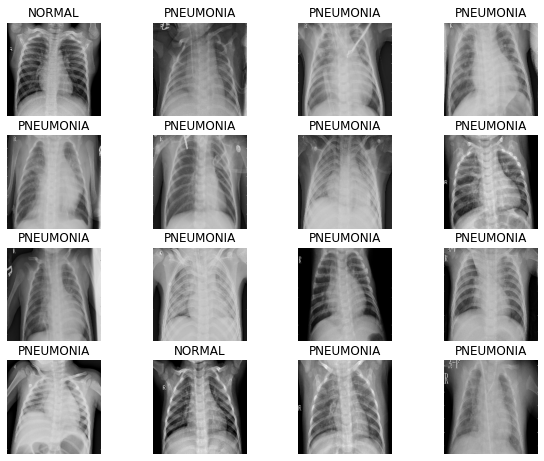

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN Modeling

CNN: First create a convolution block. The configuration of conv_block() performs convolution twice and solves gradient vanishing and gradient exploding through batch normalization. And Max Pooling.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. Handle Data Imbalance

We can say the data is imbalanced when there are too same many labels. The training may not be good enough for imbalanced data.    
To solve this, we can use `Weight balancing` technique

In [20]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))


Normal images count in training set: 1070
Pneumonia images count in training set: 3115


`weight_for_0` sets the weight to use for the 'Normal' image, and `weight_for_1` sets the weight to use for the 'Pneumonia' image. These weights are set to be inversely proportional to the total number of 'Normal' and 'Pneumonia' data.

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 6. Model Train

Let's use 'adam' as the optimizer.   
We can use 'accuracy', 'precision', and 'recall' as metrics to measure performance.

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 56s 143ms/step - loss: 0.4849 - accuracy: 0.7425 - precision: 0.9314 - recall: 0.7080 - val_loss: 0.6857 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 35s 133ms/step - loss: 0.2206 - accuracy: 0.9137 - precision: 0.9737 - recall: 0.9075 - val_loss: 1.0214 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 35s 133ms/step - loss: 0.1755 - accuracy: 0.9270 - precision: 0.9750 - recall: 0.9259 - val_loss: 0.2042 - val_accuracy: 0.9067 - val_precision: 0.8885 - val_recall: 0.9987
Epoch 4/5
261/261 [==============================] - 35s 133ms/step - loss: 0.1870 - accuracy: 0.9343 - precision: 0.9776 - recall: 0.9335 - val_loss: 0.0997 - val_accuracy: 0.9625 - val_precision: 0.9570 - val_recall: 0.9934
Epoch 5/5
261/261 [==============================] - 35s 132ms/step - loss: 0.1426 - accuracy: 0

# 7. Result and Visualization

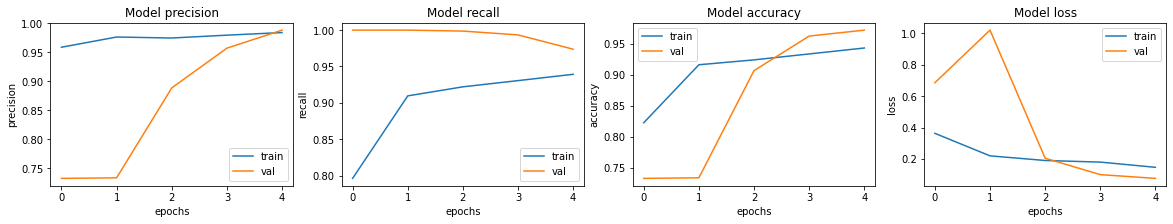

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 78ms/step - loss: 0.6222 - accuracy: 0.7933 - precision: 0.7574 - recall: 0.9846
Loss: 0.6221813559532166,
Accuracy: 0.7932692170143127,
Precision: 0.7573964595794678,
Recall: 0.9846153855323792


# Try Increase the Accuracy

I got Accuracy of 79%, so I will try to increase epochs.

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 40s 133ms/step - loss: 0.1534 - accuracy: 0.9404 - precision: 0.9821 - recall: 0.9370 - val_loss: 0.0967 - val_accuracy: 0.9644 - val_precision: 0.9853 - val_recall: 0.9659
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1274 - accuracy: 0.9552 - precision: 0.9850 - recall: 0.9543 - val_loss: 0.0741 - val_accuracy: 0.9740 - val_precision: 0.9792 - val_recall: 0.9856
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1387 - accuracy: 0.9504 - precision: 0.9856 - recall: 0.9472 - val_loss: 0.0731 - val_accuracy: 0.9769 - val_precision: 0.9868 - val_recall: 0.9816
Epoch 4/25
261/261 [==============================] - 35s 133ms/step - loss: 0.1384 - accuracy: 0.9495 - precision: 0.9849 - recall: 0.9466 - val_loss: 0.0663 - val_accuracy: 0.9750 - val_precision: 0.9780 - val_recall: 0.9882
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1378 - accura

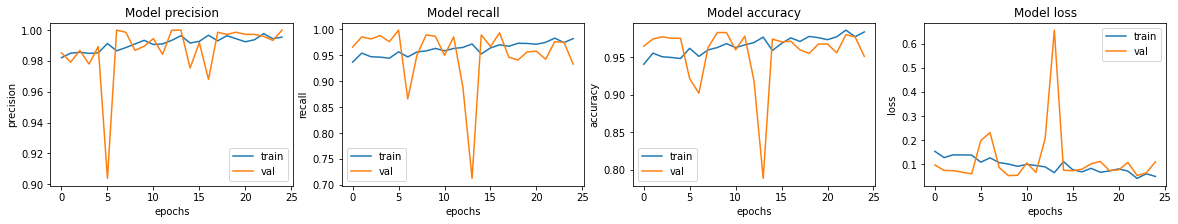

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 0.8110 - accuracy: 0.8510 - precision: 0.8293 - recall: 0.9590
Loss: 0.8110290169715881,
Accuracy: 0.8509615659713745,
Precision: 0.8292682766914368,
Recall: 0.9589743614196777


Wow I got the accuracy of 85%! ;)   


# Conclusion
# What I've learned
1. Build a CNN-based deep learning model that processes medical images is well implemented.
2. Experiment data preparation and model construction were systematically performed.
3. Run Pneumonia detection accuracy was further improved by improving the practice code.

# Challengs I've Faced
- Tried vanilla model with dropout, and data augmentation

# What to do further
- The performance of the proposed deep CNN can be compared with state-of-the-art transfer learning techniques such as AlexNet, VGG16Net and InceptionNet. I want to see how the result is different between each model.

# References
- Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift: https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf
- Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks: https://arxiv.org/pdf/1905.05928.pdf